In [ ]:
# Monolayer hBN data anlaysis

In [375]:
import nplab.datafile as df
import os
import numpy as np
import sklearn.preprocessing as skpre
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import datetime
import h5py
import scipy.signal as sig
from scipy.stats import skew
from scipy.stats import iqr
import matplotlib.cm as cm
import Alexsdatafuncs
datman = Alexsdatafuncs.data_manipulators()
from pandas import DataFrame
import peakutils
import scipy.constants as const
from lmfit.models import GaussianModel
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
from matplotlib.collections import LineCollection

In [376]:
reload(Alexsdatafuncs)
datman = Alexsdatafuncs.data_manipulators()
alexplot = Alexsdatafuncs.plotting_funcs()

In [435]:
#Colour schemes to use
colours = cm.viridis(np.linspace(0,1,100)) 
colours_2 = cm.hot(np.linspace(0,1,100))

In [ ]:
if 'hf' in globals():
    hf.close
    print "File closed"
elif 'data_f' in globals():
    data_f.close
else:
    print "No hdf5 file open"
    pass

In [ ]:
#There are two ways to open the file but both use h5py. If nplab.datafile is used the data is sorted automatically by
# timestamp, whereas h5py defaults to sort alphabetically

if 'hf' in globals():
    hf.close
    print "File closed"
else:
    pass

os.chdir('C:/Users/alexc/OneDrive - University of Cambridge/Documents/PhD Project/Projects')
data_f = df.open_file(set_current_bool=False, mode = 'r')

if data_f != None:
    data_f.show_gui()
    filoc = data_f.filename
    data_f.close()
else:
    pass

In [5]:
# create or open an HDF5 file and open in read mode
if 'filoc' not in globals():
    hf = h5py.File('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Monolayer hBN data for thesis\\Monolayer hBN on Au\\2018-11-05_sample1_60nmNPs_NaCl_cont.h5', 'r')
else:
    hf = h5py.File(filoc, 'r')
# open dark field data as an list hdf5 object
dfdata = hf.get('OceanOpticsSpectrometer')
# open image data as a list hdf5 object
imdata = hf.get('LumeneraCamera')

In [6]:
# set background, wavelength, reference and timestamp
dat0 = dfdata.get(dfdata.keys()[0])
numspec = len(dfdata.keys())
numpnts = len(dat0)
bgd = dat0.attrs['background']
wls = dat0.attrs['wavelengths']
ts = dat0.attrs['creation_timestamp']

In [7]:
# initialise matrix for dark field, timestamp and combined
dfmat = []
tsmat = []
dfmatwts = []

In [8]:
# Append into matrices the data with it properly referenced
i = 0
for i in range(0, numspec):
    temp = dfdata.get(dfdata.keys()[i])
    temparr = np.array(temp)
    dfield = (temparr - bgd) / (temp.attrs['reference'] - bgd)
    dfmat.append(dfield)
    ts = datetime.datetime.strptime(temp.attrs['creation_timestamp'][:19],
                                    "%Y-%m-%dT%H:%M:%S")
    dfwts = np.append(dfield, ts)  # append the timestamp to the end of the dataset
    dfmatwts.append(dfwts)
    #print dfdata.keys()[i]
    #print i

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  


In [9]:
# If the data isn't already sorted by timestamp then this will sort it in this way
# sort by the end timestamp value and then delete the timestamp column

dfmatwts.sort(key=lambda row: row[-1:])

In [1]:
# Paste the threshold time from the gui into variable tsthreshold and this will split into two seperate datasets

#tsthreshold = datetime.datetime.strptime("2019-03-07T15:29:24.119000", "%Y-%m-%dT%H:%M:%S.%f")
tsthreshold = datetime.datetime.strptime("2018-11-05T15:58:53.104000", "%Y-%m-%dT%H:%M:%S.%f")
dfoff = []
dfon = []
i=0
for i in range(0, len(dfmatwts)):
    if dfmatwts[i][-1] > tsthreshold:
        dfoff.append(dfmatwts[i])
    elif dfmatwts[i][-1] <= tsthreshold:
        dfon.append(dfmatwts[i])
    else:
        pass

dfoffsorted = np.delete(dfoff, -1, axis=1)
dfonsorted = np.delete(dfon, -1, axis=1)


NameError: name 'datetime' is not defined

In [11]:
len(dfoffsorted)

225

In [12]:
len(dfonsorted)

217

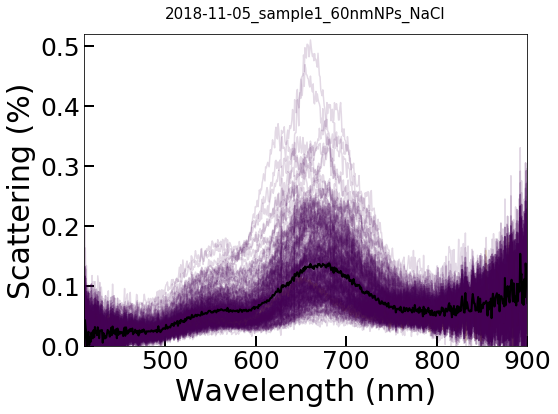

In [86]:
fig, ax, avdf_off = alexplot.plot_all_df(spectra=dfoffsorted, wls=wls, colours=colours)
ax.set_title('2018-11-05_sample1_60nmNPs_NaCl', fontsize=15, pad=15)
ax.set_ylim(0,0.52)

plt.tight_layout(pad=1.6)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\Projects\\Boron Nitride spacer\\Monolayer hBN data for thesis\\Monolayer hBN on Au\\2018-11-05_sample1_60nmNPs_NaCl_cont analysis\\60nm NPs mono hBN')

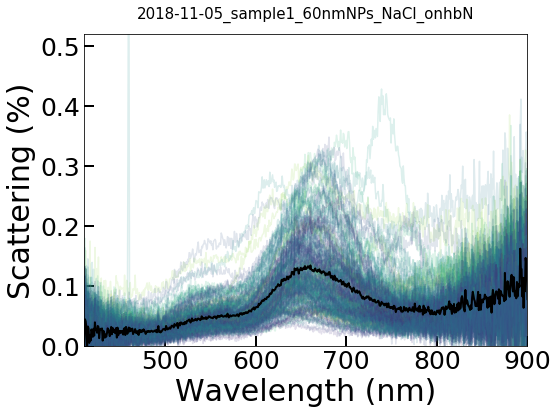

In [17]:
fig, ax, avdf_on = alexplot.plot_all_df(spectra=dfonsorted, wls=wls, colours=colours)
ax.set_title('2018-11-05_sample1_60nmNPs_NaCl_onhbN', fontsize=15, pad=15)
ax.set_ylim(0,0.52)

plt.tight_layout(pad=1.6)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\Projects\\Boron Nitride spacer\\Monolayer hBN data for thesis\\Monolayer hBN on Au\\2018-11-05_sample1_60nmNPs_NaCl_cont analysis\\60nm NPs on mono hBN')

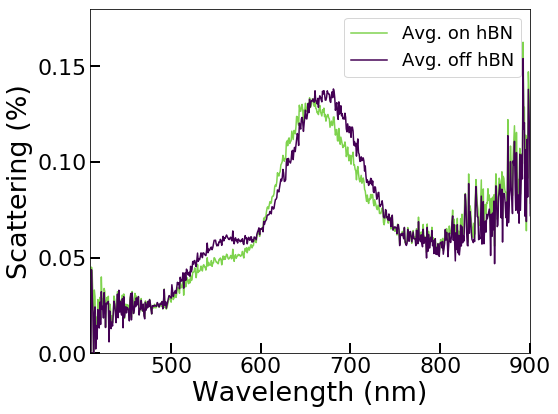

In [88]:
# Plot of average on and off on the same graph

fig = plt.figure(1, figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(wls, avdf_on*100, color=colours[80], label="Avg. on hBN")
ax.plot(wls, avdf_off*100, color=colours[0], label="Avg. off hBN")
ax.set_xlim(410,900)
ax.set_ylim(0,0.18)
ax.legend(fontsize=18)
ax.tick_params(labelsize=22, direction='in', length=10, width=2)
ax.set_xlabel("Wavelength (nm)", fontsize=27)
ax.set_ylabel("Scattering (%)", fontsize=27)
plt.tight_layout(pad=1.6)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Monolayer hBN data for thesis\\Monolayer hBN on Au\\2018-11-05_sample1_60nmNPs_NaCl_cont analysis\\Avg 60nm NP on vs off mono hBN')

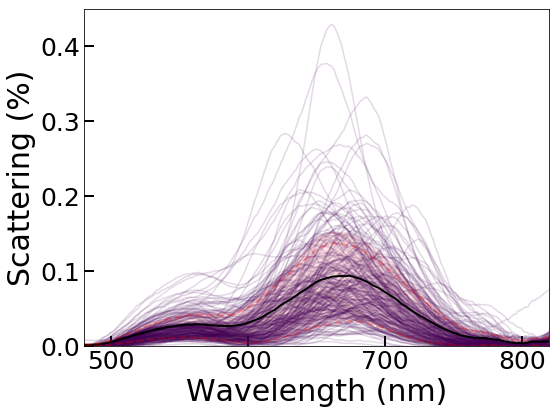

In [145]:
fig, ax, dfoff_filt,avdf_off_filt, wls_cr, std_off_filt = alexplot.plot_all_smooth_df(spectra=dfoffsorted, wls=wls, colours=colours, baseline_subtract=1,order=1, start_wl=480, end_wl=820)
ax.set_ylim(0,0.45)
plt.tight_layout(pad=1.6)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Monolayer hBN data for thesis\\Monolayer hBN on Au\\2018-11-05_sample1_60nmNPs_NaCl_cont analysis\\60nm NPs off mono hBN smooth')

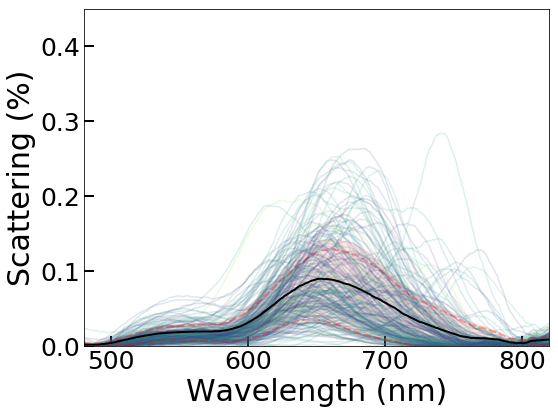

In [146]:
fig, ax, dfon_filt,avdf_on_filt, wls_cr, std_on_filt = alexplot.plot_all_smooth_df(spectra=dfonsorted, wls=wls, colours=colours, baseline_subtract=1,order=1, start_wl=480, end_wl=820)
ax.set_ylim(0,0.45)
plt.tight_layout(pad=1.6)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Monolayer hBN data for thesis\\Monolayer hBN on Au\\2018-11-05_sample1_60nmNPs_NaCl_cont analysis\\60nm NPs on mono hBN smooth')

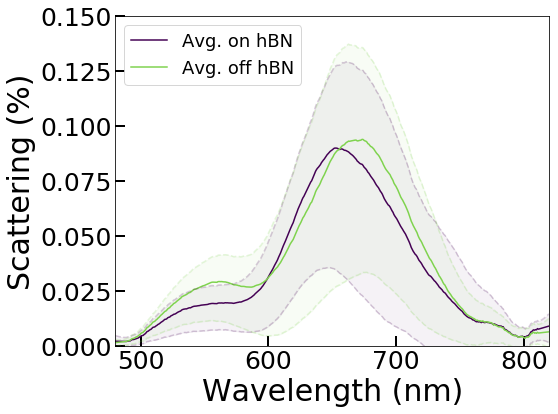

In [147]:
fig = plt.figure(1, figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(wls_cr, avdf_on_filt*100, color=colours[0], label="Avg. on hBN")
avplusdev_on = (avdf_on_filt + std_on_filt)*0.9
avmindev_on = (avdf_on_filt - std_on_filt)*0.9
avplusdev_off = (avdf_off_filt + std_off_filt)*0.9
avmindev_off = (avdf_off_filt - std_off_filt)*0.9
ax.plot(wls_cr, avdf_off_filt*100, color=colours[80], label="Avg. off hBN")
ax.plot(wls_cr, avplusdev_on*100, wls_cr, avmindev_on*100, linestyle='--', color=colours[0], alpha=0.2)
ax.plot(wls_cr, avplusdev_off*100, wls_cr, avmindev_off*100, linestyle='--', color=colours[80], alpha=0.2)
ax.fill_between(wls_cr, avmindev_on*100, avplusdev_on*100, alpha=0.05, color=colours[0])
ax.fill_between(wls_cr, avmindev_off*100, avplusdev_off*100, alpha=0.05, color=colours[80])
ax.set_xlim(480,820)
ax.set_ylim(0,0.15)
ax.legend(fontsize=18)
ax.tick_params(labelsize=25, direction='in', length=10, width=2)
ax.set_xlabel("Wavelength (nm)", fontsize=30)
ax.set_ylabel("Scattering (%)", fontsize=30)
plt.tight_layout(pad=1.6)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Monolayer hBN data for thesis\\Monolayer hBN on Au\\2018-11-05_sample1_60nmNPs_NaCl_cont analysis\\Avg 60nm NPs on vs off mono hBN smooth')

spectra same length


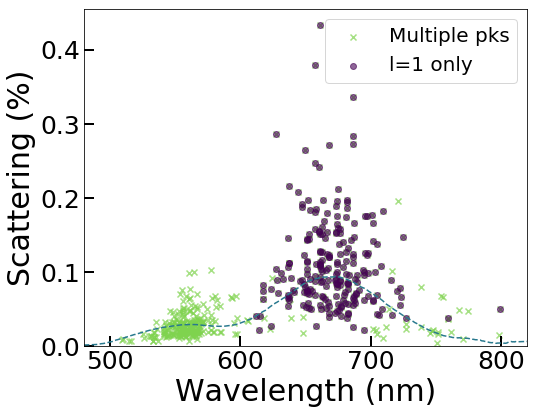

In [416]:
fig, ax, dfoff_pk_wls, dfoff_pk_ints, dfoff_pkwls_vec, dfoff_pkints_vec,\
l1_only_ints_off, l1_only_wls_off= alexplot.plot_all_peaks(spectra=dfoff_filt, wls=wls_cr, colours=colours, threshold=0.02, start_wl=505, end_wl=800)
ax.legend(fontsize=20)
ax.set_xlim(480, 820)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Monolayer hBN data for thesis\\Monolayer hBN on Au\\2018-11-05_sample1_60nmNPs_NaCl_cont analysis\\60nm NPs off mono hBN peaks and avg')

spectra same length


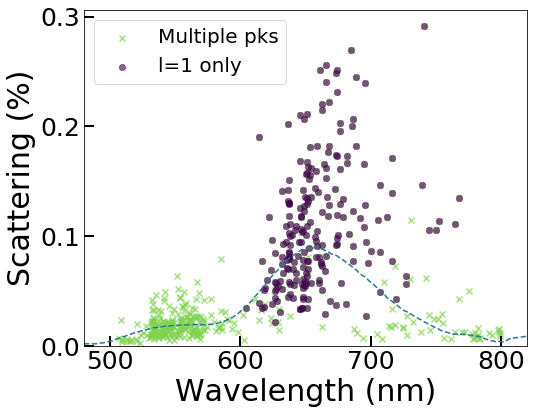

In [417]:
fig, ax, dfon_pk_wls, dfon_pk_ints, dfon_pkwls_vec, dfon_pkints_vec,\
l1_only_ints_on, l1_only_wls_on = alexplot.plot_all_peaks(spectra=dfon_filt, wls=wls_cr, colours=colours, threshold=0.02, start_wl=505, end_wl=800)
arg_zero = np.argwhere(l1_only_wls_on == np.min(l1_only_wls_on))[0][0]
l1_only_ints_on = np.delete(l1_only_ints_on, arg_zero)
l1_only_wls_on = np.delete(l1_only_wls_on, arg_zero)
ax.legend(fontsize=20)
ax.set_xlim(480, 820)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Monolayer hBN data for thesis\\Monolayer hBN on Au\\2018-11-05_sample1_60nmNPs_NaCl_cont analysis\\60nm NPs on mono hBN peaks and avg')

In [418]:
sorted_df_off = datman.sort_coupled_modes(dfoff_filt, dfoff_pk_ints, dfoff_pk_wls)

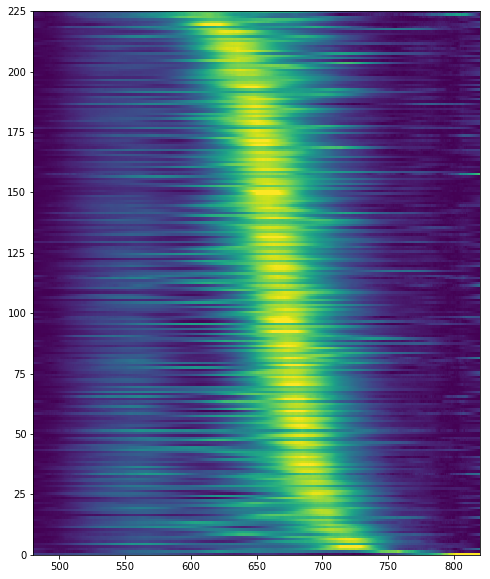

In [419]:
fig = plt.figure(1,figsize=(8,10))
ax = fig.add_subplot(111)
sorted_df_off_n = normalize(sorted_df_off)
ax.imshow((sorted_df_off_n), extent=[wls_cr[0], wls_cr[-1], 0, len(sorted_df_off_n)], 
          aspect='auto', vmin=0, vmax=np.max(sorted_df_off_n)*0.7)

In [420]:
sorted_df_on = datman.sort_coupled_modes(dfon_filt, dfon_pk_ints, dfon_pk_wls)

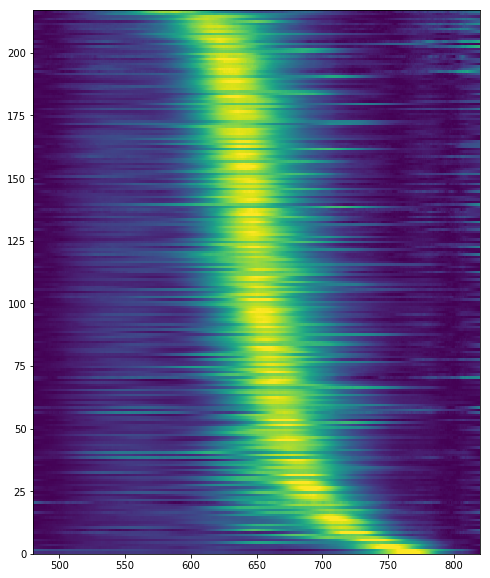

In [421]:
fig = plt.figure(1,figsize=(8,10))
ax = fig.add_subplot(111)
sorted_df_on_n = normalize(sorted_df_on)
ax.imshow((sorted_df_on_n), extent=[wls_cr[0], wls_cr[-1], 0, len(sorted_df_on_n)], 
          aspect='auto', vmin=0, vmax=np.max(sorted_df_on_n)*0.9)

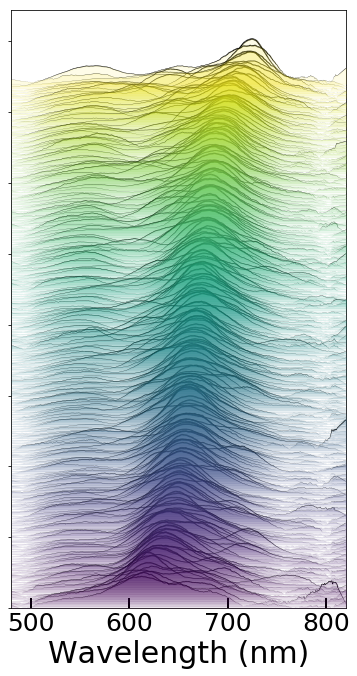

In [402]:
fig, ax, sorted_offset_off = alexplot.offset_map(spectra=sorted_df_off_n[:-1], wls=wls_cr, lthickness=12, offset_fact=0.05)
ax.set_xticks(np.arange(500,900, 100))
ax.set_xlim(480, 820)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Monolayer hBN data for thesis\\Monolayer hBN on Au\\2018-11-05_sample1_60nmNPs_NaCl_cont analysis\\60nm NPs off mono hBN all DF norm')

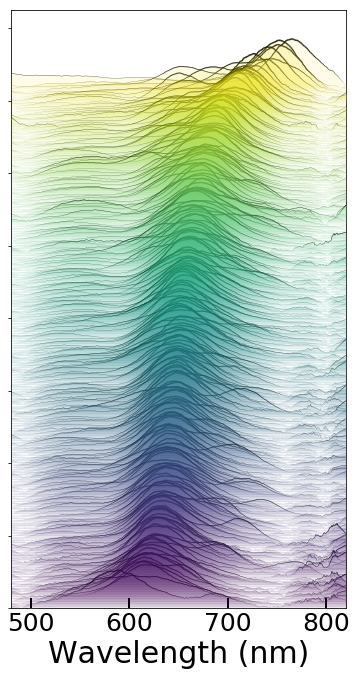

In [303]:
fig, ax, sorted_offset_off = alexplot.offset_map(spectra=sorted_df_on_n, wls=wls_cr, lthickness=12, offset_fact=0.05)
ax.set_xticks(np.arange(500,900, 100))
ax.set_xlim(480, 820)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Monolayer hBN data for thesis\\Monolayer hBN on Au\\2018-11-05_sample1_60nmNPs_NaCl_cont analysis\\60nm NPs on mono hBN all DF norm')

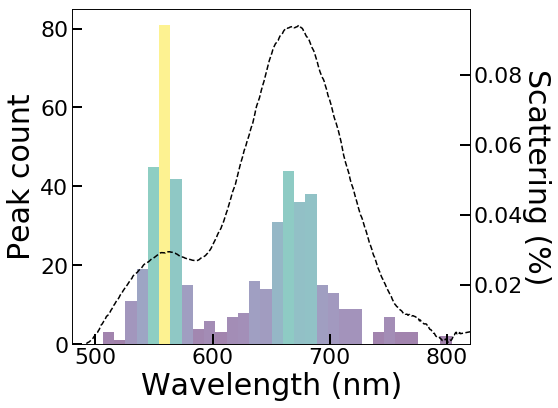

In [422]:
# Count number of histogram peaks above a certain threshold and use for kmeans
fig, ax, ax2, n_off, bins_off = alexplot.peak_histogram(allpkwls=dfoff_pkwls_vec, wls=wls_cr, colours=colours, av_spectrum=avdf_off_filt)
ax.set_xlim(480,820)
ax.set_ylim(0, 85)
ax2.set_ylim(0.003,)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Monolayer hBN data for thesis\\Monolayer hBN on Au\\2018-11-05_sample1_60nmNPs_NaCl_cont analysis\\60nm NPs off mono hBN pk hist')

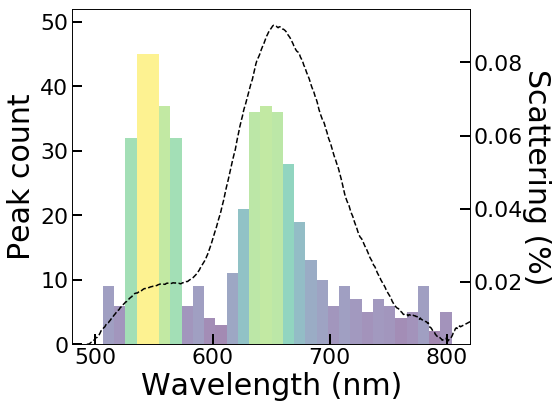

In [423]:
# Count number of histogram peaks above a certain threshold and use for kmeans
fig, ax, ax2, n_on, bins_on = alexplot.peak_histogram(allpkwls=dfon_pkwls_vec, wls=wls_cr, colours=colours, av_spectrum=avdf_on_filt)
ax.set_xlim(480,820)
ax.set_ylim(0, 52)
ax2.set_ylim(0.003,)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Monolayer hBN data for thesis\\Monolayer hBN on Au\\2018-11-05_sample1_60nmNPs_NaCl_cont analysis\\60nm NPs on mono hBN pk hist')

array([[6.78170638e+02, 1.02322508e-03],
       [5.60326406e+02, 3.04061348e-04]])

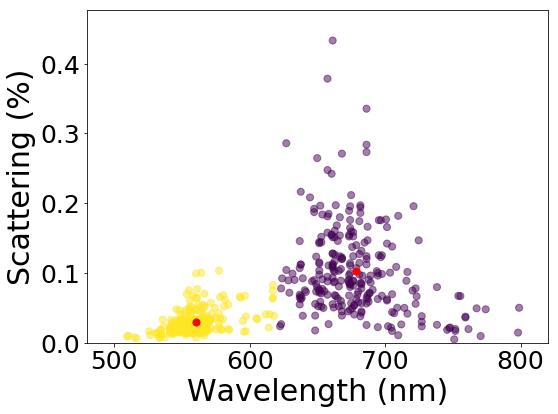

In [332]:
#Use kmeans to find peak centres
clust_num = 2
fig, ax, dframe, kmeans_off, centroids_off, labels = alexplot.kmeans_pkplot(dfoff_pkwls_vec, dfoff_pkints_vec, n_clusters=clust_num)
ax.set_ylim(0, max(dframe['y'] * 110))
ax.set_xlim(480, 820)
ax.set_xlabel("Wavelength (nm)", fontsize=30)
ax.set_ylabel("Scattering (%)", fontsize=30)
ax.tick_params(axis='x', labelsize=25), ax.tick_params(axis='y', labelsize=25)
fig.tight_layout(pad=1.6)

int_arr = np.arange(0, clust_num, 1)
columns_off = [str(i) for i in int_arr]

dframe_off = pd.DataFrame(columns=columns_off)
i=0

for i in range(0, len(labels)):
    j=0
    for j in range(len(columns_off)):
        if labels[i] == j:
            dframe_off = dframe_off.append({str(j): dfoff_pkwls_vec[i]}, ignore_index=True)
            
        

fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Monolayer hBN data for thesis\\Monolayer hBN on Au\\2018-11-05_sample1_60nmNPs_NaCl_cont analysis\\60nm NPs off mono hBN kmeans')
centroids_off

In [334]:
centroid_num = 0
l1_mode_pkwl_off = []
l1_mode_pkint_off = []
colours_2 = []
for i in range(0, len(dframe_off[str(centroid_num)])):
    if np.isnan(dframe_off[str(centroid_num)][i]) == False:
        l1_mode_pkwl_off.append(dframe_off[str(centroid_num)][i])
        l1_mode_pkint_off.append(dfoff_pkints_vec[i])
        colours_2.append(kmeans_off.labels_.astype(float)[i])
    else:
        pass

In [424]:
argmaxint = np.argmax(l1_only_wls_off)
l1_only_wls_off = np.delete(l1_only_wls_off,argmaxint)
l1_only_ints_off = np.delete(l1_only_ints_off,argmaxint)

0.17446160961282073

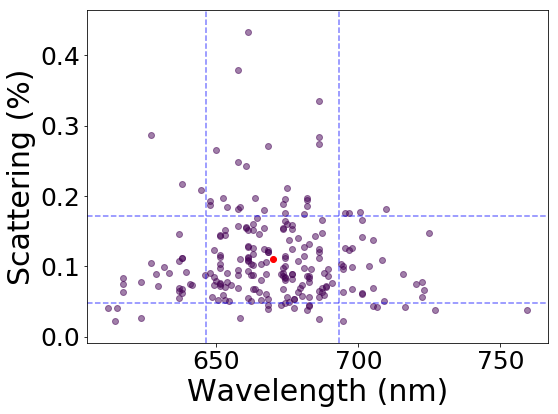

In [450]:
fig = plt.figure(1, figsize=(8,6))
ax = fig.add_subplot(111)
ax.scatter(l1_only_wls_off, l1_only_ints_off*100, alpha=0.5, color = colours[0])
mean_dipole_off = np.mean(l1_only_wls_off)
mean_dipole_off_int = np.mean(l1_only_ints_off*100)
ax.scatter(mean_dipole_off, mean_dipole_off_int, color='r')
std_dipole_off = np.std(l1_only_wls_off)
std_dipole_off_int = np.std(l1_only_ints_off*100)
ax.axvline(mean_dipole_off+std_dipole_off, linestyle='--', color='blue',alpha=0.5)
ax.axvline(mean_dipole_off-std_dipole_off, linestyle='--', color='blue', alpha=0.5)
ax.axhline(mean_dipole_off_int+std_dipole_off_int, linestyle='--', color='blue', alpha=0.5)
ax.axhline(mean_dipole_off_int-std_dipole_off_int, linestyle='--', color='blue', alpha=0.5)
ax.set_ylabel("Scattering (%)", fontsize=30)
ax.set_xlabel("Wavelength (nm)", fontsize=30)
ax.tick_params(labelsize=25)

ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tight_layout(pad=1.6)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Monolayer hBN data for thesis\\Monolayer hBN on Au\\2018-11-05_sample1_60nmNPs_NaCl_cont analysis\\60nm NPs off mono hBN maxint peak dist')
skew(l1_only_wls_off)

In [451]:
mean_dipole_off

669.8264073194413

In [452]:
std_dipole_off

23.499082254296386

In [453]:
mean_dipole_off_int

0.11009236011128938

In [454]:
std_dipole_off_int

0.06173724509000497

In [427]:
skew(l1_only_ints_off)

1.739569862092685

In [428]:
iqr(l1_only_wls_off)

28.995292444186816

array([[5.51223504e+02, 2.01434035e-04],
       [6.74672562e+02, 9.03760237e-04]])

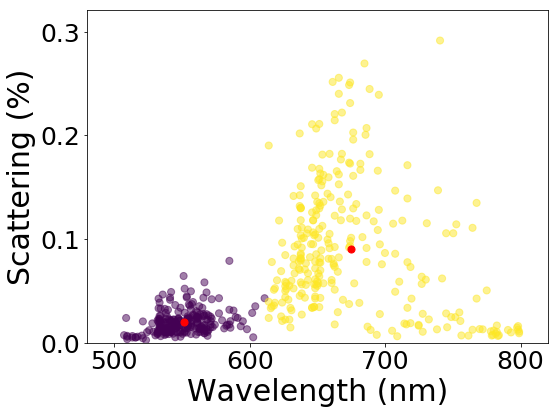

In [400]:
#Test kmeans to find peak centres
clust_num=2
fig, ax, dframe, kmeans_on, centroids_on, labels = alexplot.kmeans_pkplot(dfon_pkwls_vec, dfon_pkints_vec, n_clusters=clust_num)
ax.set_ylim(0, max(dframe['y'] * 110))
ax.set_xlim(480, 820)
ax.set_xlabel("Wavelength (nm)", fontsize=30)
ax.set_ylabel("Scattering (%)", fontsize=30)
ax.tick_params(labelsize=25)
fig.tight_layout(pad=1.6)

int_arr = np.arange(0, clust_num, 1)
columns_on = [str(i) for i in int_arr]

dframe_on = pd.DataFrame(columns=columns_on)
i=0

for i in range(0, len(labels)):
    j=0
    for j in range(len(columns_on)):
        if labels[i] == j:
            dframe_on = dframe_on.append({str(j): dfon_pkwls_vec[i]}, ignore_index=True)

fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Monolayer hBN data for thesis\\Monolayer hBN on Au\\2018-11-05_sample1_60nmNPs_NaCl_cont analysis\\60nm NPs on mono hBN kmeans')
centroids_on

In [343]:
centroid_num = 1
l1_mode_pkwl_on = []
l1_mode_pkint_on = []
colours_2 = []
for i in range(0, len(dframe_on[str(centroid_num)])):
    if np.isnan(dframe_on[str(centroid_num)][i]) == False:
        l1_mode_pkwl_on.append(dframe_on[str(centroid_num)][i])
        l1_mode_pkint_on.append(dfon_pkints_vec[i])
        colours_2.append(kmeans_on.labels_.astype(float)[i])
    else:
        pass

1.2720209584063622

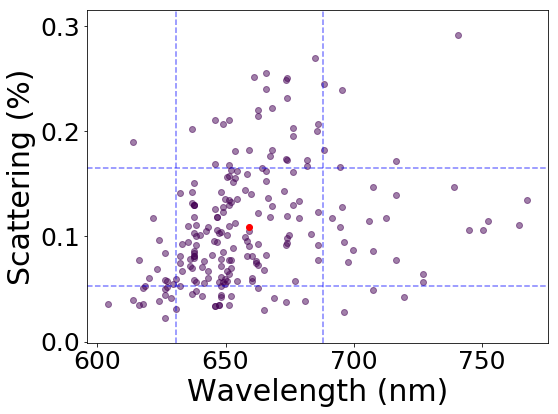

In [437]:
# plotting the peak positions of all peaks with highest intensity for each spectrum

fig = plt.figure(1, figsize=(8,6))
ax = fig.add_subplot(111)
ax.scatter(l1_only_wls_on, l1_only_ints_on*100, alpha=0.5, color=colours[0])
mean_dipole_on = np.mean(l1_only_wls_on)
mean_dipole_on_int = np.mean(l1_only_ints_on*100)
ax.scatter(mean_dipole_on, mean_dipole_on_int, color='r')
std_dipole_on = np.std(l1_only_wls_on)
std_dipole_on_int = np.std(l1_only_ints_on*100)
ax.axvline(mean_dipole_on+std_dipole_on, linestyle='--', color='blue',alpha=0.5)
ax.axvline(mean_dipole_on-std_dipole_on, linestyle='--', color='blue', alpha=0.5)
ax.axhline(mean_dipole_on_int+std_dipole_on_int, linestyle='--', color='blue', alpha=0.5)
ax.axhline(mean_dipole_on_int-std_dipole_on_int, linestyle='--', color='blue', alpha=0.5)
ax.set_ylabel("Scattering (%)", fontsize=30)
ax.set_xlabel("Wavelength (nm)", fontsize=30)
ax.tick_params(labelsize=25)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tight_layout(pad=1.6)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Monolayer hBN data for thesis\\Monolayer hBN on Au\\2018-11-05_sample1_60nmNPs_NaCl_cont analysis\\60nm NPs on mono hBN maxint peak dist')
skew(l1_only_wls_on)


In [455]:
mean_dipole_on

659.344174593914

In [456]:
std_dipole_on

28.783010653967747

In [457]:
mean_dipole_on_int

0.10880311316945186

In [458]:
std_dipole_on_int

0.056475460070386486

In [426]:
skew(l1_only_ints_on)

0.8455299499481355

In [429]:
iqr(l1_only_wls_on)

34.924883003361174

In [215]:
# Iterate through and create matrix containing gaussian fits for each spectrum
fit_mat_off = []
for i in range(0, len(dfoff_filt)):
    print "Fitting spectrum: " + str(i) + " of " + str(len(dfoff_filt))
    fit = datman.gaussian_fit_2(x_data=wls_cr, y_data=dfoff_filt[i], x_peak_indexes=dfoff_pk_wls[i], y_peak_values=dfoff_pk_ints[i])
    fit_mat_off.append(fit)

Fitting spectrum: 0 of 225
Fitting spectrum: 1 of 225
Fitting spectrum: 2 of 225
Fitting spectrum: 3 of 225
Fitting spectrum: 4 of 225
Fitting spectrum: 5 of 225
Fitting spectrum: 6 of 225
Fitting spectrum: 7 of 225
Fitting spectrum: 8 of 225
Fitting spectrum: 9 of 225
Fitting spectrum: 10 of 225
Fitting spectrum: 11 of 225
Fitting spectrum: 12 of 225
Fitting spectrum: 13 of 225
Fitting spectrum: 14 of 225
Fitting spectrum: 15 of 225
Fitting spectrum: 16 of 225
Fitting spectrum: 17 of 225
Fitting spectrum: 18 of 225
Fitting spectrum: 19 of 225
Fitting spectrum: 20 of 225
Fitting spectrum: 21 of 225
Fitting spectrum: 22 of 225
Fitting spectrum: 23 of 225
Fitting spectrum: 24 of 225
Fitting spectrum: 25 of 225
Fitting spectrum: 26 of 225
Fitting spectrum: 27 of 225
Fitting spectrum: 28 of 225
Fitting spectrum: 29 of 225
Fitting spectrum: 30 of 225
Fitting spectrum: 31 of 225
Fitting spectrum: 32 of 225
Fitting spectrum: 33 of 225
Fitting spectrum: 34 of 225
Fitting spectrum: 35 of 225
Fi

In [216]:
# Iterate through and create matrix containing gaussian fits for each spectrum
fit_mat_on = []
for i in range(0, len(dfon_filt)):
    print "Fitting spectrum: " + str(i) + " of " + str(len(dfon_filt))
    fit = datman.gaussian_fit_2(x_data=wls_cr, y_data=dfon_filt[i], x_peak_indexes=dfon_pk_wls[i], y_peak_values=dfon_pk_ints[i])
    fit_mat_on.append(fit)
    

Fitting spectrum: 0 of 217
Fitting spectrum: 1 of 217
Fitting spectrum: 2 of 217
Fitting spectrum: 3 of 217
Fitting spectrum: 4 of 217
Fitting spectrum: 5 of 217
Fitting spectrum: 6 of 217
Fitting spectrum: 7 of 217
Fitting spectrum: 8 of 217
Fitting spectrum: 9 of 217
Fitting spectrum: 10 of 217
Fitting spectrum: 11 of 217
Fitting spectrum: 12 of 217
Fitting spectrum: 13 of 217
Fitting spectrum: 14 of 217
Fitting spectrum: 15 of 217
Fitting spectrum: 16 of 217
Fitting spectrum: 17 of 217
Fitting spectrum: 18 of 217
Fitting spectrum: 19 of 217
Fitting spectrum: 20 of 217
Fitting spectrum: 21 of 217
Fitting spectrum: 22 of 217
Fitting spectrum: 23 of 217
Fitting spectrum: 24 of 217
Fitting spectrum: 25 of 217
Fitting spectrum: 26 of 217
Fitting spectrum: 27 of 217
Fitting spectrum: 28 of 217
Fitting spectrum: 29 of 217
Fitting spectrum: 30 of 217
Fitting spectrum: 31 of 217
Fitting spectrum: 32 of 217
Fitting spectrum: 33 of 217
Fitting spectrum: 34 of 217
Fitting spectrum: 35 of 217
Fi

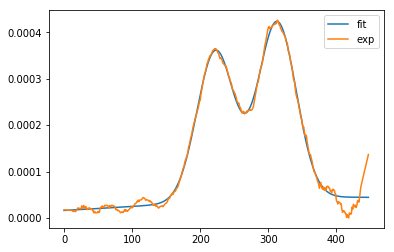

In [217]:
test_n = 131
plt.plot(fit_mat_on[test_n].best_fit, label='fit')
plt.plot(dfon_filt[test_n], label = 'exp')
plt.legend()


In [218]:
# Calculate Q factors for each mode and each spectrum
fit_plots_off = []
i=0
for i in range(0, len(fit_mat_off)):
    fit_plots_off.append(fit_mat_off[i].best_fit)
    
q_factors_off, max_ints_off, fwhms_off = datman.q_factor_calc(x_data=wls_cr, y_data=fit_plots_off)

In [219]:
fit_l1_wls_off = np.zeros(len(fit_mat_off))
for i in range(len(fit_mat_off)):
    arg_max = np.argwhere(fit_mat_off[i].best_fit == np.max(fit_mat_off[i].best_fit))[0][0]
    pk_posn = wls_cr[arg_max]
    fit_l1_wls_off[i] = pk_posn

In [224]:
q_factors_off = np.delete(q_factors_off, np.argwhere(q_factors_off > 20)[0][0])

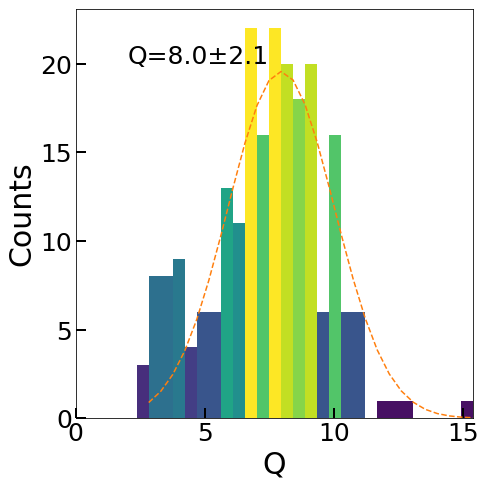

In [225]:
q_factors_off = np.array(q_factors_off)
fig, ax, n_off, bins_off = alexplot.default_hist(q_factors_off, colours=colours)
ax.set_xlabel("Q", fontsize=30)
ax.set_ylabel('Counts', fontsize=30)
ax.tick_params(labelsize=25, direction='in', size=10, width=2)
multi_gauss_a = GaussianModel(prefix='g' + str(0) + '_')
multi_gauss_fit_a = multi_gauss_a.fit(n_off, x=bins_off[1:])
ax.plot(bins_off[1:],multi_gauss_fit_a.best_fit, linestyle='--')
qcentre = np.round(multi_gauss_fit_a.best_values.get('g0_center'),1)
qsigma = np.round(multi_gauss_fit_a.best_values.get('g0_sigma'),1)
ax.text(2, 20,"Q="+str(qcentre)+ u'\u00b1'+str(qsigma), fontsize=25)
multi_gauss_fit_a.best_values
ax.set_xlim(0,)
plt.tight_layout(pad=1.6)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Monolayer hBN data for thesis\\Monolayer hBN on Au\\2018-11-05_sample1_60nmNPs_NaCl_cont analysis\\60nm NPs off mono hBN Qfactors')


In [226]:
# Calculate Q factors for each mode and each spectrum
fit_plots_on = []
i=0
for i in range(0, len(fit_mat_on)):
    fit_plots_on.append(fit_mat_on[i].best_fit)
    
q_factors_on, max_ints_on, fwhms_on = datman.q_factor_calc(x_data=wls_cr, y_data=fit_plots_on)

In [227]:
fit_l1_wls_on = np.zeros(len(fit_mat_on))
i=0
for i in range(len(fit_mat_on)):
    arg_max = np.argwhere(fit_mat_on[i].best_fit == np.max(fit_mat_on[i].best_fit))[0][0]
    pk_posn = wls_cr[arg_max]
    fit_l1_wls_on[i] = pk_posn

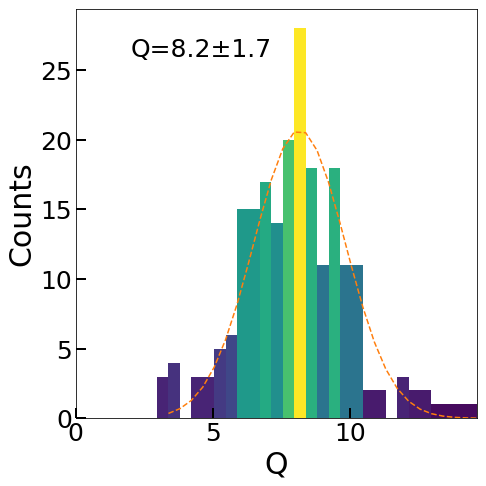

In [228]:
q_factors_on = np.array(q_factors_on)
fig,ax, n_on, bins_on = alexplot.default_hist(q_factors_on[q_factors_on < 18], colours=colours)
ax.set_xlabel("Q", fontsize=30)
ax.set_ylabel('Counts', fontsize=30)
ax.tick_params(labelsize=25, direction='in', size=10, width=2)
multi_gauss_a = GaussianModel(prefix='g' + str(0) + '_')
multi_gauss_fit_a = multi_gauss_a.fit(n_on, x=bins_on[1:])
ax.plot(bins_on[1:],multi_gauss_fit_a.best_fit, linestyle='--')
qcentre = np.round(multi_gauss_fit_a.best_values.get('g0_center'),1)
qsigma = np.round(multi_gauss_fit_a.best_values.get('g0_sigma'),1)
ax.text(2, 26,"Q="+str(qcentre)+ u'\u00b1'+str(qsigma), fontsize=25)
multi_gauss_fit_a.best_values
ax.set_xlim(0,)
plt.tight_layout(pad=1.6)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Monolayer hBN data for thesis\\Monolayer hBN on Au\\2018-11-05_sample1_60nmNPs_NaCl_cont analysis\\60nm NPs on mono hBN Qfactors')


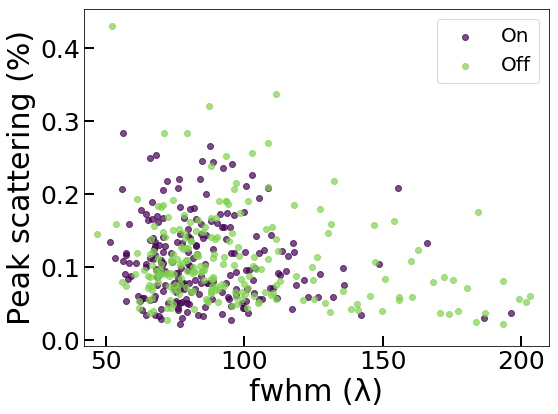

In [449]:
#combine all data into single set and see if kmeans can distinguish between sets of data

fig = plt.figure(1, figsize = (8,6))
ax = fig.add_subplot(111)
ax.scatter(fwhms_on, [i*100 for i in max_ints_on], color=colours[0], marker='o', label='On', alpha=0.7)
ax.scatter(fwhms_off, [i*100 for i in max_ints_off], color=colours[80], marker='o', label='Off', alpha=0.7)
#ax.plot(xp,p(xp))
ax.set_xlabel(u"fwhm (\u03BB)", fontsize = 30)
ax.set_ylabel("Peak scattering (%)", fontsize = 30)
ax.set_xlim(42,210)
ax.tick_params(labelsize=25, direction='in', size=10, width=2)
ax.legend(fontsize=20)
plt.tight_layout(pad=1.6)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Monolayer hBN data for thesis\\Monolayer hBN on Au\\2018-11-05_sample1_60nmNPs_NaCl_cont analysis\\60nm NPs on off mono hBN pkscat vs fwhm')


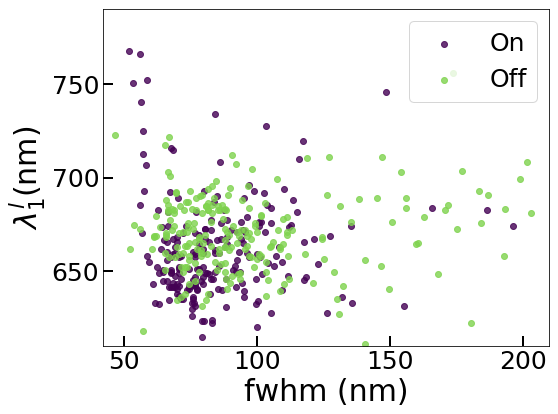

In [448]:
fig = plt.figure(1, figsize = (8,6))
ax = fig.add_subplot(111)
ax.scatter(fwhms_on, fit_l1_wls_on, color=colours[0], marker='o', alpha=0.8, label='On')
ax.scatter(fwhms_off, fit_l1_wls_off, color=colours[80], marker='o', alpha=0.8, label='Off')
ax.set_xlabel(u"fwhm (nm)", fontsize = 30)
ax.set_ylabel("$\lambda_1^l$(nm)", fontsize = 30)
ax.set_xlim(42,210)
ax.set_ylim(610, 790)
ax.tick_params(labelsize=25, direction='in', size=10, width=2)
ax.legend(fontsize=25)
plt.tight_layout(pad=1.6)
fig.savefig('C:\\Users\\alexc\\OneDrive - University of Cambridge\\Documents\\PhD Project\\Projects\\Boron Nitride spacer\\Monolayer hBN data for thesis\\Monolayer hBN on Au\\2018-11-05_sample1_60nmNPs_NaCl_cont analysis\\60nm NPs on off mono hBN wl_l1 vs fwhm')
